In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')


In [24]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define paths to data folders
MACRO_FOLDER = '/content/drive/MyDrive/processed_data'
FINANCIAL_FOLDER = '/content/drive/MyDrive/financial_info'

def load_and_process_data(country):
    """
    Load and process data for a specific country, standardizing dates and frequencies
    """
    print(f"Processing {country}...")

    try:
        # Define file paths
        macro_path = f"{MACRO_FOLDER}/{country}_macro.csv"
        stock_path = f"{FINANCIAL_FOLDER}/{country}_stock.csv"

        # Load macro data
        macro_df = pd.read_csv(macro_path)

        # Convert date column to datetime
        macro_df['date'] = pd.to_datetime(macro_df['date'])

        # Clean redundant columns in macro data (handling _x and _y duplicates)
        clean_macro = pd.DataFrame()
        clean_macro['date'] = macro_df['date']

        # Track processed base columns to avoid duplicates
        processed_cols = set()

        # Process each column, handling the _x and _y suffix duplicates
        for col in macro_df.columns:
            if col == 'date':
                continue

            # Get base column name (without suffix)
            base_col = col.split('_')[0]

            # Skip if we've already processed this base column
            if base_col in processed_cols:
                continue

            # Choose the best version of the column (prioritize non-suffixed)
            if base_col in macro_df.columns:
                clean_macro[base_col] = pd.to_numeric(macro_df[base_col], errors='coerce')
            elif f"{base_col}_x" in macro_df.columns:
                clean_macro[base_col] = pd.to_numeric(macro_df[f"{base_col}_x"], errors='coerce')
            elif f"{base_col}_y" in macro_df.columns:
                clean_macro[base_col] = pd.to_numeric(macro_df[f"{base_col}_y"], errors='coerce')

            processed_cols.add(base_col)

        # Load stock data, handling the empty first row often present in the files
        with open(stock_path, 'r') as f:
            first_line = f.readline().strip()

        skip_rows = 1 if first_line == '' or ',^' in first_line or ',EZA' in first_line else 0
        stock_df = pd.read_csv(stock_path, skiprows=skip_rows)

        # Handle case sensitivity in column names
        date_col = 'Date' if 'Date' in stock_df.columns else 'date'
        close_col = 'Close' if 'Close' in stock_df.columns else 'close'

        # Create standardized stock dataframe
        stock_clean = pd.DataFrame()
        stock_clean['date'] = pd.to_datetime(stock_df[date_col])
        stock_clean['close'] = pd.to_numeric(stock_df[close_col], errors='coerce')

        # Remove timezone information if present
        if hasattr(stock_clean['date'].dt, 'tz') and stock_clean['date'].dt.tz is not None:
            stock_clean['date'] = stock_clean['date'].dt.tz_localize(None)

        # Set date as index for both dataframes
        clean_macro.set_index('date', inplace=True)
        stock_clean.set_index('date', inplace=True)

        # Resample macro data to monthly frequency with forward fill
        # This converts quarterly data to monthly by carrying forward the last known value
        monthly_macro = clean_macro.resample('M').ffill()

        # Ensure stock data is also on monthly frequency
        monthly_stock = stock_clean.resample('M').last()

        # Merge the dataframes on their date indices
        merged_df = pd.merge(
            monthly_stock,
            monthly_macro,
            left_index=True,
            right_index=True,
            how='inner'
        )

        print(f"Successfully processed {country} data: {len(merged_df)} rows, {merged_df.shape[1]} columns")
        print(f"Date range: {merged_df.index.min()} to {merged_df.index.max()}")

        return merged_df

    except Exception as e:
        print(f"Error processing {country}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


Mounted at /content/drive


In [25]:
def engineer_features(df):
    """Create features for the market regime classification model"""
    # Create a copy to avoid modifying the original
    result = df.copy()

    # Price-based features
    result['return_1q'] = result['close'].pct_change(1)     # 1-quarter return
    result['return_2q'] = result['close'].pct_change(2)     # 2-quarter return
    result['volatility_2q'] = result['return_1q'].rolling(2).std()  # 2-quarter volatility

    # Macro features
    for col in ['GDP', 'CPI', 'UNEMPLOYMENT', 'IMPORTS', 'EXPORTS', 'INTEREST_RATE', 'EXCHANGE_RATE']:
        if col in result.columns:
            result[f'{col}_change'] = result[col].pct_change(1)  # Quarter-over-quarter change

    # Interaction features
    if 'INTEREST_RATE' in result.columns and 'CPI' in result.columns:
        # Real interest rate (inflation-adjusted)
        result['real_interest_rate'] = result['INTEREST_RATE'] - result['CPI_change']

    if 'EXPORTS' in result.columns and 'IMPORTS' in result.columns:
        # Trade balance
        result['trade_balance'] = result['EXPORTS'] - result['IMPORTS']
        result['trade_balance_to_gdp'] = result['trade_balance'] / result['GDP'] if 'GDP' in result.columns else np.nan

    # Drop rows with missing values in key features
    result = result.dropna(subset=['return_1q', 'close'])

    return result


In [26]:
def label_market_regimes(df, window=6, threshold=0.5):
    """
    Label market regimes:
    0 = Bearish, 1 = Range-bound, 2 = Bullish
    """
    if df is None or df.empty:
        return None

    result = df.copy()

    # Calculate rolling statistics for price
    rolling_mean = result['close'].rolling(window=window).mean()
    rolling_std = result['close'].rolling(window=window).std()

    # Create boundaries for regime classification
    upper_bound = rolling_mean + (rolling_std * threshold)
    lower_bound = rolling_mean - (rolling_std * threshold)

    # Initialize all regimes as range-bound (1)
    result['regime'] = 1

    # Classify bullish regime (2) when price above upper bound
    result.loc[result['close'] > upper_bound, 'regime'] = 2

    # Classify bearish regime (0) when price below lower bound
    result.loc[result['close'] < lower_bound, 'regime'] = 0

    # Enhance with macroeconomic conditions
    if 'GDP_change' in result.columns and 'return_3m' in result.columns:
        # Strong bullish confirmation: positive GDP growth + positive returns
        bullish_confirmation = (result['GDP_change'] > 0) & (result['return_3m'] > 0)
        result.loc[bullish_confirmation, 'regime'] = 2

        # Strong bearish confirmation: negative GDP growth + negative returns
        bearish_confirmation = (result['GDP_change'] < 0) & (result['return_3m'] < 0)
        result.loc[bearish_confirmation, 'regime'] = 0

    return result

In [27]:
def build_regime_classification_model(X_train, y_train):
    """
    Build and train a Support Vector Classifier for market regime classification

    Parameters:
    -----------
    X_train : DataFrame
        Training features
    y_train : Series
        Target variable (market regimes)

    Returns:
    --------
    model : Pipeline
        Trained classification model with preprocessing steps
    """
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import StandardScaler
    from sklearn.svm import SVC

    # Check for NaN values in training data
    if X_train.isna().any().any():
        print(f"Warning: Training data contains {X_train.isna().sum().sum()} NaN values")

    # Create pipeline with preprocessing and model
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
        ('scaler', StandardScaler()),                 # Scale features
        ('classifier', SVC(C=1.0, gamma='scale', probability=True))  # SVM classifier
    ])

    # Train the model
    pipeline.fit(X_train, y_train)

    return pipeline


In [28]:
def train_and_evaluate_model(country_data):
    """Train and evaluate the SVC market regime classification model"""
    try:
        # Features to use
        features = [
            'return_1q', 'return_2q', 'volatility_2q',
            'GDP_change', 'CPI_change', 'IMPORTS_change', 'EXPORTS_change',
            'INTEREST_RATE_change', 'EXCHANGE_RATE_change'
        ]

        # Filter to available features
        available_features = [f for f in features if f in country_data.columns]

        # Extract features and target
        X = country_data[available_features].copy()
        y = country_data['regime']

        # Split data (maintaining chronological order)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, shuffle=False
        )

        print(f"Training on {len(X_train)} samples, testing on {len(X_test)} samples")

        # Build and train model
        model = build_regime_classification_model(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred)

        print(f"Model Accuracy: {accuracy:.2f}")
        print("\nConfusion Matrix:")
        print(conf_matrix)
        print("\nClassification Report:")
        print(class_report)

        return model, X_test, y_test, y_pred

    except Exception as e:
        print(f"Error in train_and_evaluate_model: {str(e)}")
        import traceback
        traceback.print_exc()
        # Return None values to maintain the expected return structure
        return None, None, None, None



In [29]:
def visualize_results(data, X_test, y_test, y_pred, country):
    """Create visualizations of model results"""
    if data is None or X_test is None:
        return

    # Get dates corresponding to test set
    test_dates = X_test.index

    # Create dataframe for plotting
    plot_df = pd.DataFrame(index=test_dates)
    plot_df['close'] = data.loc[test_dates, 'close']
    plot_df['actual_regime'] = y_test
    plot_df['predicted_regime'] = y_pred

    # Create multi-panel figure
    fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

    # Plot 1: Stock price
    axes[0].plot(plot_df.index, plot_df['close'], 'b-', linewidth=2)
    axes[0].set_title(f'{country.upper()} - Market Price', fontsize=16)
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Actual regimes
    axes[1].scatter(plot_df.index, plot_df['actual_regime'], s=80, c=plot_df['actual_regime'],
                   cmap='viridis', alpha=0.7)
    axes[1].set_title('Actual Market Regimes', fontsize=14)
    axes[1].set_yticks([0, 1, 2])
    axes[1].set_yticklabels(['Bearish', 'Range-bound', 'Bullish'])
    axes[1].grid(True, alpha=0.3)

    # Plot 3: Predicted regimes
    axes[2].scatter(plot_df.index, plot_df['predicted_regime'], s=80,
                   c=plot_df['predicted_regime'], cmap='viridis', alpha=0.7)
    axes[2].set_title('Predicted Market Regimes', fontsize=14)
    axes[2].set_yticks([0, 1, 2])
    axes[2].set_yticklabels(['Bearish', 'Range-bound', 'Bullish'])
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{country}_regime_classification.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    conf_mat = confusion_matrix(plot_df['actual_regime'], plot_df['predicted_regime'])
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Bearish', 'Range-bound', 'Bullish'],
               yticklabels=['Bearish', 'Range-bound', 'Bullish'])
    plt.title(f'{country.upper()} - Confusion Matrix', fontsize=14)
    plt.xlabel('Predicted Regime', fontsize=12)
    plt.ylabel('True Regime', fontsize=12)
    plt.tight_layout()
    plt.savefig(f"{country}_confusion_matrix.png", dpi=300, bbox_inches='tight')
    plt.show()

In [30]:
def run_classification(country_data):
    """Train and evaluate market regime classification model"""
    if country_data is None or country_data.empty:
        return None, None, None, None

    # Select features for classification
    features = [col for col in country_data.columns
                if col not in ['close', 'regime'] and
                not pd.isna(country_data[col]).all()]

    # Extract features and target
    X = country_data[features]
    y = country_data['regime']

    # Split data (maintaining chronological order)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, shuffle=False
    )

    print(f"Training on {len(X_train)} samples, testing on {len(X_test)} samples")

    # Build and train model
    model = build_svc_model(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print(f"Model Accuracy: {accuracy:.2f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)

    return model, X_test, y_test, y_pred


In [31]:
def analyze_feature_importance(model, X, country):
    """Analyze and visualize feature importance"""
    # For linear SVC kernels, we can extract coefficients directly
    if hasattr(model[-1], 'coef_'):
        # Get feature names
        feature_names = X.columns

        # Get coefficients
        coefficients = model[-1].coef_[0]

        # Create DataFrame for visualization
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': np.abs(coefficients)
        })

        # Sort by importance
        importance_df = importance_df.sort_values('Importance', ascending=False)

        # Plot
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=importance_df)
        plt.title(f'{country} - Feature Importance for Market Regime Classification', fontsize=14)
        plt.xlabel('Absolute Coefficient Magnitude', fontsize=12)
        plt.tight_layout()
        plt.savefig(f"{country}_feature_importance.png", dpi=300, bbox_inches='tight')
        plt.show()

        return importance_df
    else:
        print("Feature importance visualization not available for non-linear kernels")
        return None


In [32]:
def debug_model_training(country_data, country_name):
    """
    Debug function to visualize training and evaluation process for market regime classification

    Parameters:
    country_data (DataFrame): Processed data with features and regime labels
    country_name (str): Name of the country for plot titles

    Returns:
    dict: Dictionary containing debug information and visualizations
    """
    debug_info = {}

    try:
        print(f"\n{'='*50}")
        print(f"DEBUGGING MODEL FOR {country_name.upper()}")
        print(f"{'='*50}")

        # 1. Check data structure and availability
        print("\n1. Data Structure Check:")
        print(f"   - Data shape: {country_data.shape}")
        print(f"   - Columns: {country_data.columns.tolist()}")
        print(f"   - Date range: {country_data.index.min()} to {country_data.index.max()}")

        # Check for missing values
        missing = country_data.isnull().sum()
        print(f"   - Columns with missing values: {missing[missing > 0].to_dict()}")

        # 2. Check regime distribution
        if 'regime' in country_data.columns:
            regime_counts = country_data['regime'].value_counts()
            print("\n2. Regime Distribution:")
            print(f"   - {regime_counts.to_dict()}")

            # Visualize regime distribution
            plt.figure(figsize=(10, 6))
            ax = regime_counts.plot(kind='bar', color=['red', 'gray', 'green'])
            plt.title(f"{country_name} - Market Regime Distribution", fontsize=14)
            plt.xlabel("Regime (0=Bearish, 1=Range-bound, 2=Bullish)", fontsize=12)
            plt.ylabel("Count", fontsize=12)
            plt.grid(axis='y', alpha=0.3)

            # Add count labels on bars
            for i, v in enumerate(regime_counts):
                ax.text(i, v + 0.5, str(v), ha='center', fontsize=12)

            plt.tight_layout()
            plt.show()

            # Visualize regimes over time
            plt.figure(figsize=(12, 6))
            plt.plot(country_data.index, country_data['close'], 'b-', label='Price')
            plt.scatter(country_data.index, country_data['close'],
                       c=country_data['regime'], cmap='viridis', s=50, alpha=0.7)
            plt.colorbar(label='Regime (0=Bearish, 1=Range-bound, 2=Bullish)')
            plt.title(f"{country_name} - Market Price and Regimes Over Time", fontsize=14)
            plt.xlabel("Date", fontsize=12)
            plt.ylabel("Price", fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.tight_layout()
            plt.show()
        else:
            print("\n2. Regime Distribution: 'regime' column not found!")

        # 3. Feature availability check
        features = [
            'return_1q', 'return_2q', 'volatility_2q',
            'GDP_change', 'CPI_change', 'IMPORTS_change', 'EXPORTS_change',
            'INTEREST_RATE_change', 'EXCHANGE_RATE_change'
        ]

        available_features = [f for f in features if f in country_data.columns]
        missing_features = [f for f in features if f not in country_data.columns]

        print("\n3. Feature Availability:")
        print(f"   - Available features: {available_features}")
        print(f"   - Missing features: {missing_features}")

        # 4. Feature correlation analysis
        if available_features:
            print("\n4. Feature Correlation Analysis:")

            # Calculate correlations with regime
            if 'regime' in country_data.columns:
                correlations = {}
                for feature in available_features:
                    corr = country_data[feature].corr(country_data['regime'])
                    correlations[feature] = corr
                    print(f"   - {feature} correlation with regime: {corr:.3f}")

                # Visualize correlations
                plt.figure(figsize=(12, 6))
                plt.bar(correlations.keys(), correlations.values())
                plt.title(f"{country_name} - Feature Correlations with Market Regime", fontsize=14)
                plt.xlabel("Features", fontsize=12)
                plt.ylabel("Correlation Coefficient", fontsize=12)
                plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
                plt.grid(axis='y', alpha=0.3)
                plt.xticks(rotation=45, ha='right')
                plt.tight_layout()
                plt.show()

        # 5. Perform the actual model training and evaluation
        try:
            print("\n5. Model Training and Evaluation:")

            # Extract features and target
            X = country_data[available_features].copy()
            y = country_data['regime']

            # Split data (maintaining chronological order)
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, shuffle=False
            )

            print(f"   - Training on {len(X_train)} samples, testing on {len(X_test)} samples")
            print(f"   - Training data shape: {X_train.shape}")
            print(f"   - Test data shape: {X_test.shape}")

            # Check for NaN values in training and test sets
            train_nans = X_train.isna().sum().sum()
            test_nans = X_test.isna().sum().sum()
            print(f"   - NaN values in training set: {train_nans}")
            print(f"   - NaN values in test set: {test_nans}")

            # Build and train model
            model = build_regime_classification_model(X_train, y_train)

            # Make predictions
            y_pred = model.predict(X_test)

            # Calculate evaluation metrics
            accuracy = accuracy_score(y_test, y_pred)
            conf_matrix = confusion_matrix(y_test, y_pred)
            class_report = classification_report(y_test, y_pred)

            print(f"   - Model Accuracy: {accuracy:.2f}")
            print("\n   - Confusion Matrix:")
            print(conf_matrix)
            print("\n   - Classification Report:")
            print(class_report)

            # Visualize results
            # Plot 1: Actual vs Predicted Regimes
            plt.figure(figsize=(14, 10))

            # Create a DataFrame for plotting
            plot_df = pd.DataFrame(index=X_test.index)
            plot_df['close'] = country_data.loc[X_test.index, 'close']
            plot_df['actual_regime'] = y_test
            plot_df['predicted_regime'] = y_pred

            # Subplot 1: Price
            plt.subplot(3, 1, 1)
            plt.plot(plot_df.index, plot_df['close'], 'b-', linewidth=2)
            plt.title(f'{country_name} - Market Price', fontsize=14)
            plt.grid(True, alpha=0.3)

            # Subplot 2: Actual Regimes
            plt.subplot(3, 1, 2)
            plt.scatter(plot_df.index, plot_df['actual_regime'], s=80, c=plot_df['actual_regime'],
                       cmap='viridis', alpha=0.7)
            plt.title('Actual Market Regimes', fontsize=14)
            plt.yticks([0, 1, 2], ['Bearish', 'Range-bound', 'Bullish'])
            plt.grid(True, alpha=0.3)

            # Subplot 3: Predicted Regimes
            plt.subplot(3, 1, 3)
            plt.scatter(plot_df.index, plot_df['predicted_regime'], s=80,
                       c=plot_df['predicted_regime'], cmap='viridis', alpha=0.7)
            plt.title('Predicted Market Regimes', fontsize=14)
            plt.yticks([0, 1, 2], ['Bearish', 'Range-bound', 'Bullish'])
            plt.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

            # Plot 2: Confusion Matrix
            plt.figure(figsize=(8, 6))
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                       xticklabels=['Bearish', 'Range-bound', 'Bullish'],
                       yticklabels=['Bearish', 'Range-bound', 'Bullish'])
            plt.title(f'{country_name} - Confusion Matrix', fontsize=14)
            plt.xlabel('Predicted Regime', fontsize=12)
            plt.ylabel('True Regime', fontsize=12)
            plt.tight_layout()
            plt.show()

            # Store results in debug_info
            debug_info['model'] = model
            debug_info['X_test'] = X_test
            debug_info['y_test'] = y_test
            debug_info['y_pred'] = y_pred
            debug_info['accuracy'] = accuracy

            return debug_info

        except Exception as e:
            print(f"\nError in model training: {str(e)}")
            import traceback
            traceback.print_exc()
            return None

    except Exception as e:
        print(f"\nError in debug_model_training: {str(e)}")
        import traceback
        traceback.print_exc()
        return None



Processing BRAZIL
Processing brazil...
Successfully processed brazil data: 146 rows, 5 columns
Date range: 2013-03-31 00:00:00 to 2025-04-30 00:00:00
Engineered features. Shape: (145, 14)
Regime distribution:
regime
2    71
1    38
0    36
Name: count, dtype: int64

DEBUGGING MODEL FOR BRAZIL

1. Data Structure Check:
   - Data shape: (145, 15)
   - Columns: ['close', 'IMPORTS', 'EXPORTS', 'GDP', 'CPI', 'return_1q', 'return_2q', 'volatility_2q', 'GDP_change', 'CPI_change', 'IMPORTS_change', 'EXPORTS_change', 'trade_balance', 'trade_balance_to_gdp', 'regime']
   - Date range: 2013-04-30 00:00:00 to 2025-04-30 00:00:00
   - Columns with missing values: {'IMPORTS': 5, 'EXPORTS': 5, 'GDP': 17, 'CPI': 11, 'return_2q': 1, 'volatility_2q': 1, 'GDP_change': 18, 'CPI_change': 12, 'IMPORTS_change': 6, 'EXPORTS_change': 6, 'trade_balance': 5, 'trade_balance_to_gdp': 17}

2. Regime Distribution:
   - {2: 71, 1: 38, 0: 36}


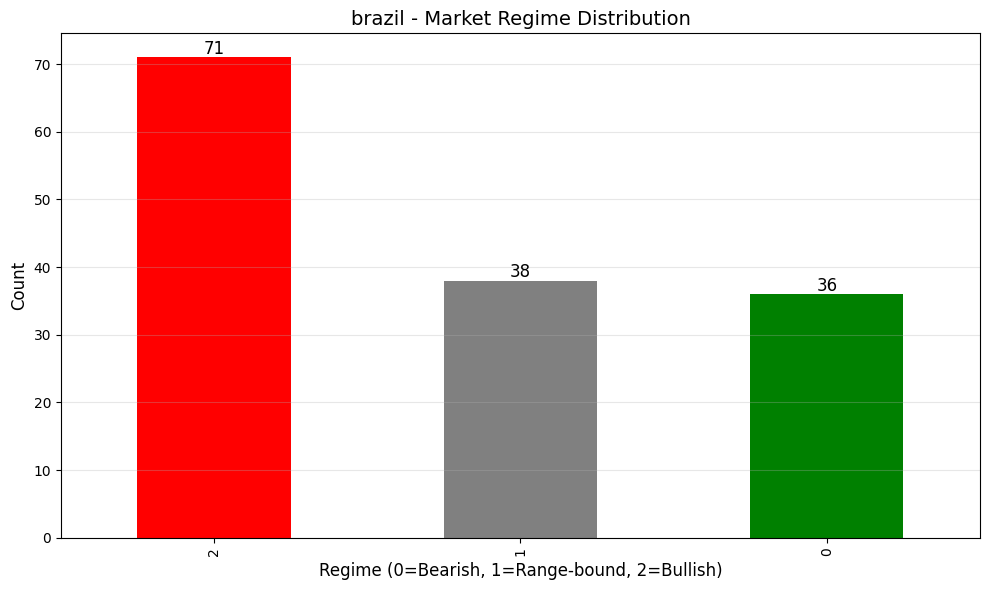

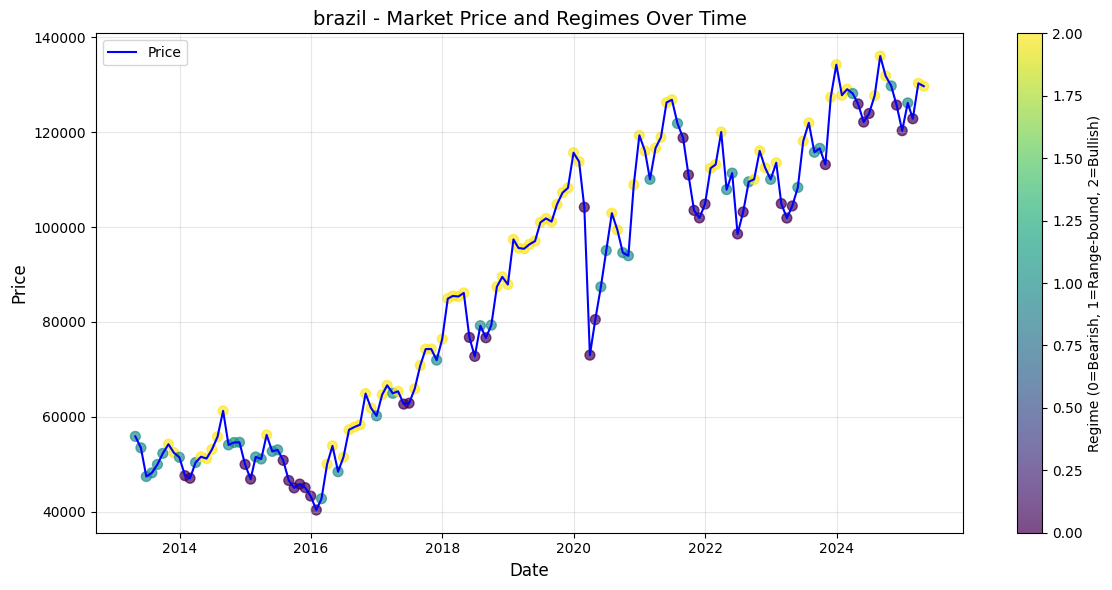


3. Feature Availability:
   - Available features: ['return_1q', 'return_2q', 'volatility_2q', 'GDP_change', 'CPI_change', 'IMPORTS_change', 'EXPORTS_change']
   - Missing features: ['INTEREST_RATE_change', 'EXCHANGE_RATE_change']

4. Feature Correlation Analysis:
   - return_1q correlation with regime: 0.514
   - return_2q correlation with regime: 0.665
   - volatility_2q correlation with regime: -0.048
   - GDP_change correlation with regime: 0.038
   - CPI_change correlation with regime: 0.003
   - IMPORTS_change correlation with regime: -0.118
   - EXPORTS_change correlation with regime: -0.021


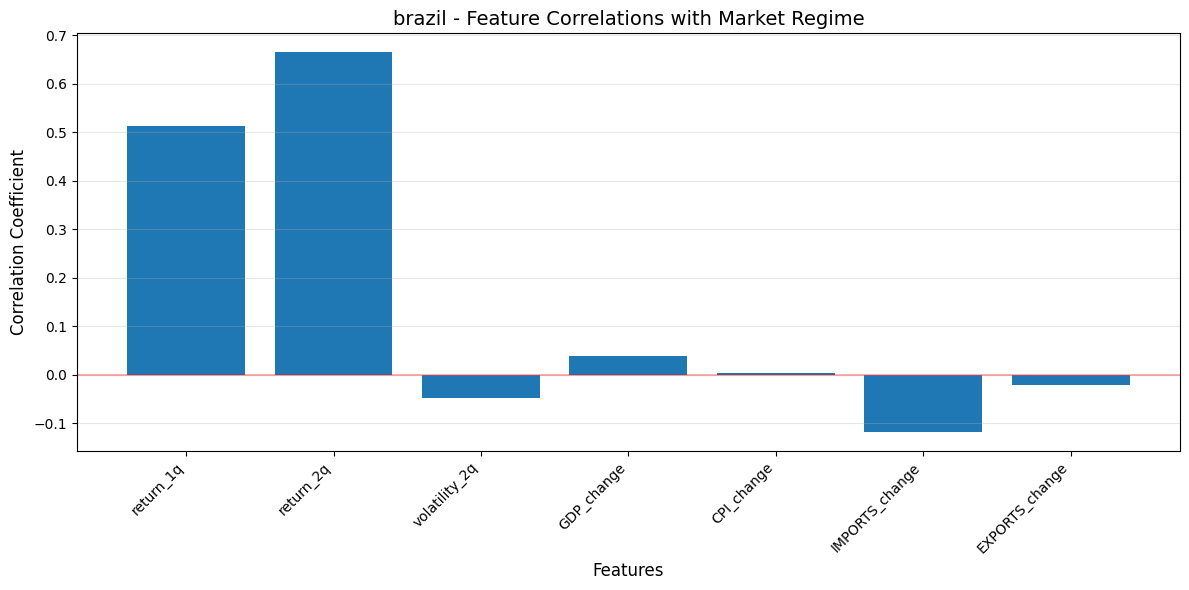


5. Model Training and Evaluation:
   - Training on 101 samples, testing on 44 samples
   - Training data shape: (101, 7)
   - Test data shape: (44, 7)
   - NaN values in training set: 44
   - NaN values in test set: 0
   - Model Accuracy: 0.59

   - Confusion Matrix:
[[ 7  2  7]
 [ 1  3  6]
 [ 0  2 16]]

   - Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.44      0.58        16
           1       0.43      0.30      0.35        10
           2       0.55      0.89      0.68        18

    accuracy                           0.59        44
   macro avg       0.62      0.54      0.54        44
weighted avg       0.64      0.59      0.57        44



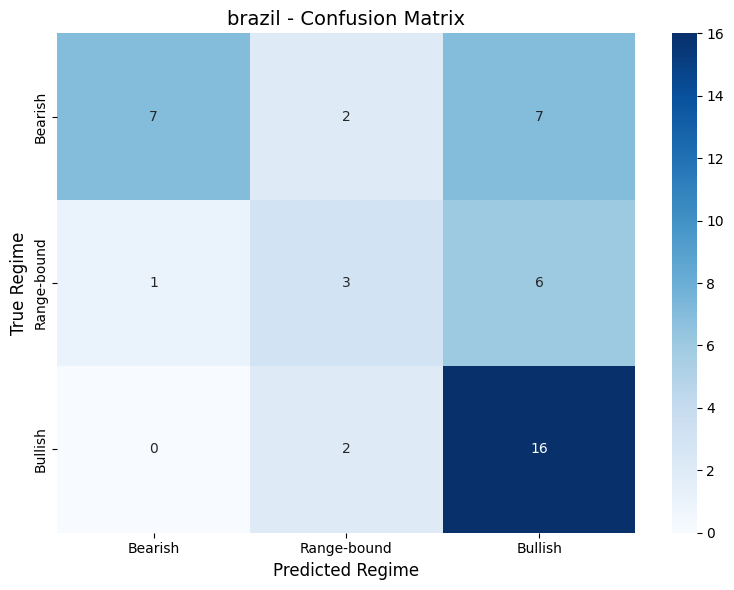


Processing INDIA
Processing india...
Successfully processed india data: 146 rows, 5 columns
Date range: 2013-03-31 00:00:00 to 2025-04-30 00:00:00
Engineered features. Shape: (145, 14)
Regime distribution:
regime
2    79
1    38
0    28
Name: count, dtype: int64

DEBUGGING MODEL FOR INDIA

1. Data Structure Check:
   - Data shape: (145, 15)
   - Columns: ['close', 'IMPORTS', 'EXPORTS', 'GDP', 'CPI', 'return_1q', 'return_2q', 'volatility_2q', 'GDP_change', 'CPI_change', 'IMPORTS_change', 'EXPORTS_change', 'trade_balance', 'trade_balance_to_gdp', 'regime']
   - Date range: 2013-04-30 00:00:00 to 2025-04-30 00:00:00
   - Columns with missing values: {'IMPORTS': 5, 'EXPORTS': 5, 'GDP': 20, 'CPI': 20, 'return_2q': 1, 'volatility_2q': 1, 'GDP_change': 21, 'CPI_change': 21, 'IMPORTS_change': 6, 'EXPORTS_change': 6, 'trade_balance': 5, 'trade_balance_to_gdp': 20}

2. Regime Distribution:
   - {2: 79, 1: 38, 0: 28}


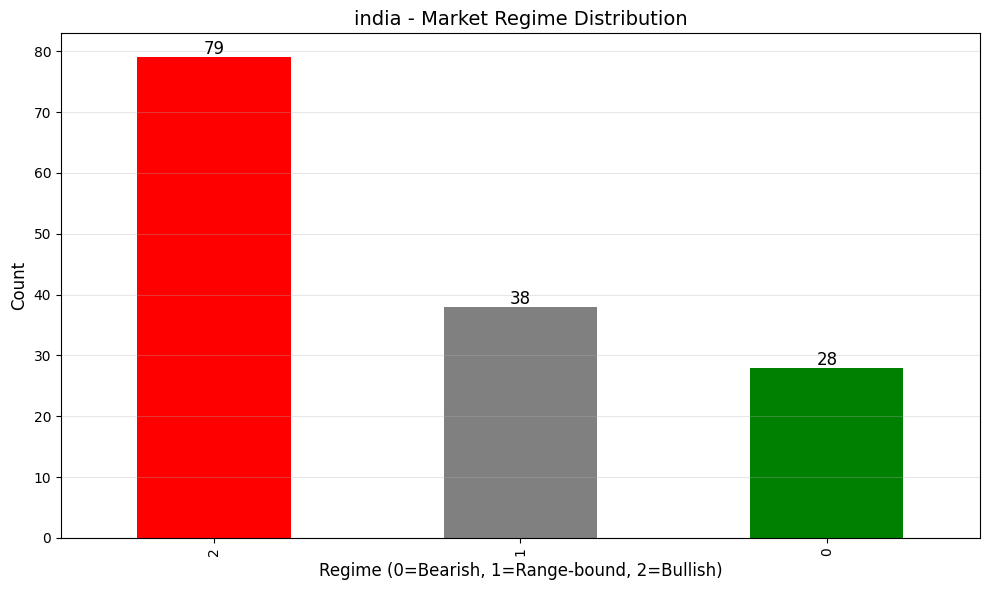


3. Feature Availability:
   - Available features: ['return_1q', 'return_2q', 'volatility_2q', 'GDP_change', 'CPI_change', 'IMPORTS_change', 'EXPORTS_change']
   - Missing features: ['INTEREST_RATE_change', 'EXCHANGE_RATE_change']

4. Feature Correlation Analysis:
   - return_1q correlation with regime: 0.520
   - return_2q correlation with regime: 0.697
   - volatility_2q correlation with regime: -0.116
   - GDP_change correlation with regime: 0.017
   - CPI_change correlation with regime: 0.010
   - IMPORTS_change correlation with regime: 0.105
   - EXPORTS_change correlation with regime: 0.085



5. Model Training and Evaluation:
   - Training on 101 samples, testing on 44 samples
   - Training data shape: (101, 7)
   - Test data shape: (44, 7)
   - NaN values in training set: 56
   - NaN values in test set: 0
   - Model Accuracy: 0.61

   - Confusion Matrix:
[[ 2  7  0]
 [ 3  3  5]
 [ 0  2 22]]

   - Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.22      0.29         9
           1       0.25      0.27      0.26        11
           2       0.81      0.92      0.86        24

    accuracy                           0.61        44
   macro avg       0.49      0.47      0.47        44
weighted avg       0.59      0.61      0.59        44



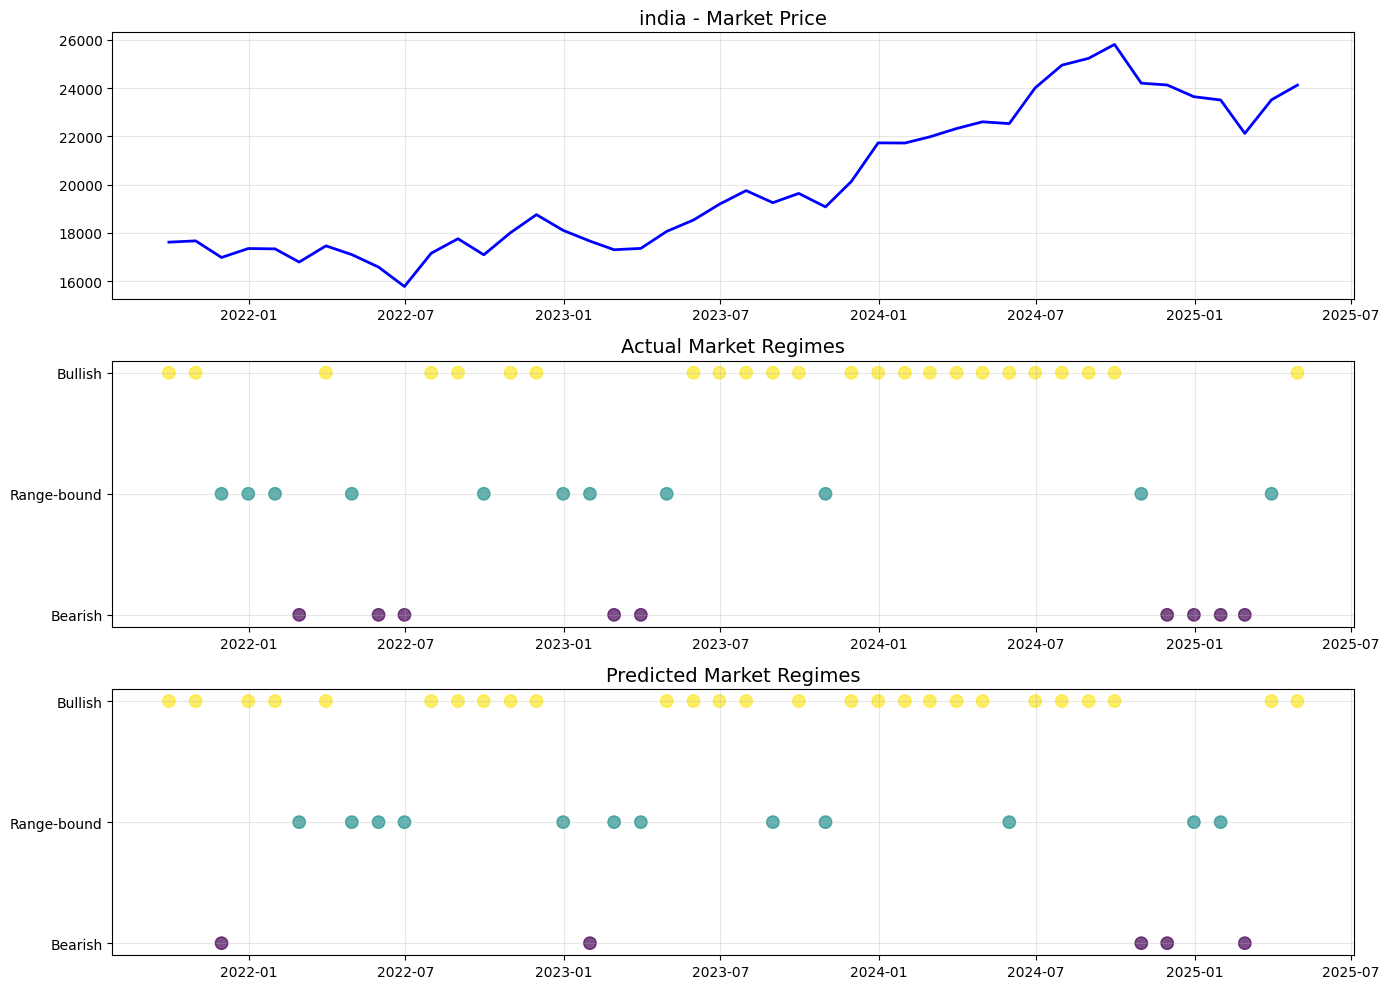

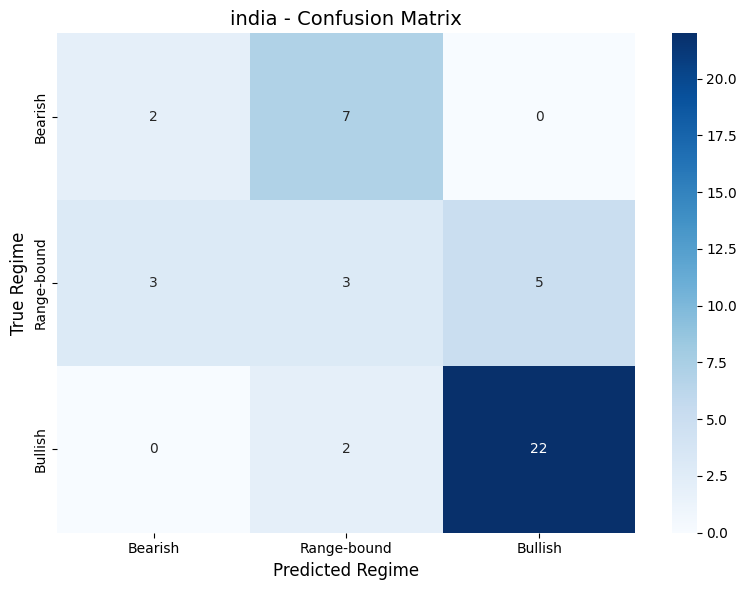


Processing SOUTH_AFRICA
Processing south_africa...
Successfully processed south_africa data: 146 rows, 6 columns
Date range: 2013-03-31 00:00:00 to 2025-04-30 00:00:00
Engineered features. Shape: (145, 16)
Regime distribution:
regime
2    58
0    46
1    41
Name: count, dtype: int64

DEBUGGING MODEL FOR SOUTH_AFRICA

1. Data Structure Check:
   - Data shape: (145, 17)
   - Columns: ['close', 'UNEMPLOYMENT', 'GDP', 'IMPORTS', 'EXPORTS', 'CPI', 'return_1q', 'return_2q', 'volatility_2q', 'GDP_change', 'CPI_change', 'UNEMPLOYMENT_change', 'IMPORTS_change', 'EXPORTS_change', 'trade_balance', 'trade_balance_to_gdp', 'regime']
   - Date range: 2013-04-30 00:00:00 to 2025-04-30 00:00:00
   - Columns with missing values: {'UNEMPLOYMENT': 20, 'GDP': 20, 'IMPORTS': 5, 'EXPORTS': 5, 'CPI': 8, 'return_2q': 1, 'volatility_2q': 1, 'GDP_change': 21, 'CPI_change': 9, 'UNEMPLOYMENT_change': 21, 'IMPORTS_change': 6, 'EXPORTS_change': 6, 'trade_balance': 5, 'trade_balance_to_gdp': 20}

2. Regime Distribu

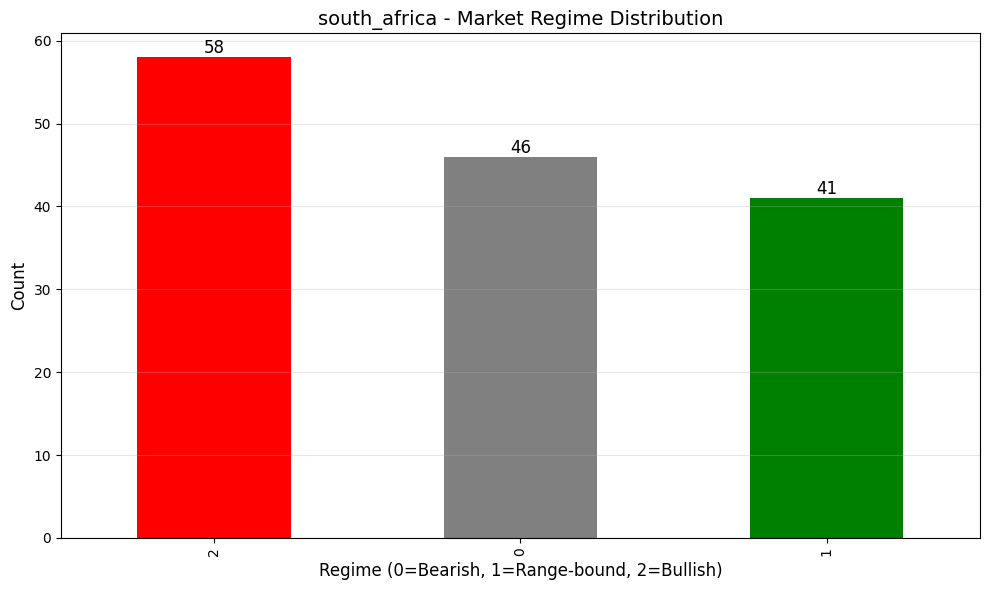

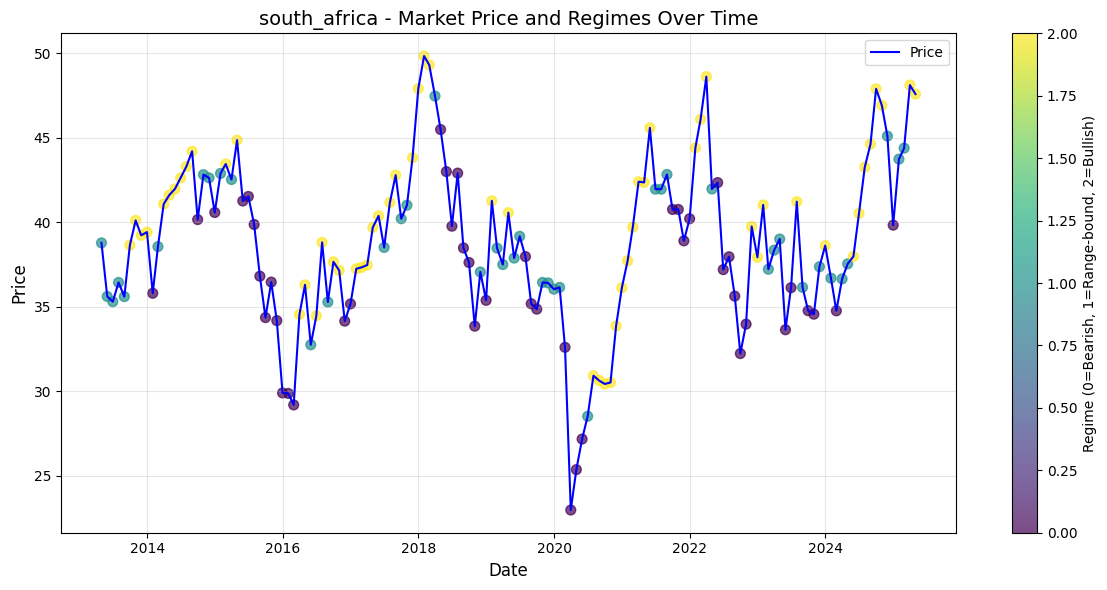


3. Feature Availability:
   - Available features: ['return_1q', 'return_2q', 'volatility_2q', 'GDP_change', 'CPI_change', 'IMPORTS_change', 'EXPORTS_change']
   - Missing features: ['INTEREST_RATE_change', 'EXCHANGE_RATE_change']

4. Feature Correlation Analysis:
   - return_1q correlation with regime: 0.544
   - return_2q correlation with regime: 0.728
   - volatility_2q correlation with regime: -0.200
   - GDP_change correlation with regime: 0.071
   - CPI_change correlation with regime: -0.032
   - IMPORTS_change correlation with regime: -0.003
   - EXPORTS_change correlation with regime: 0.044


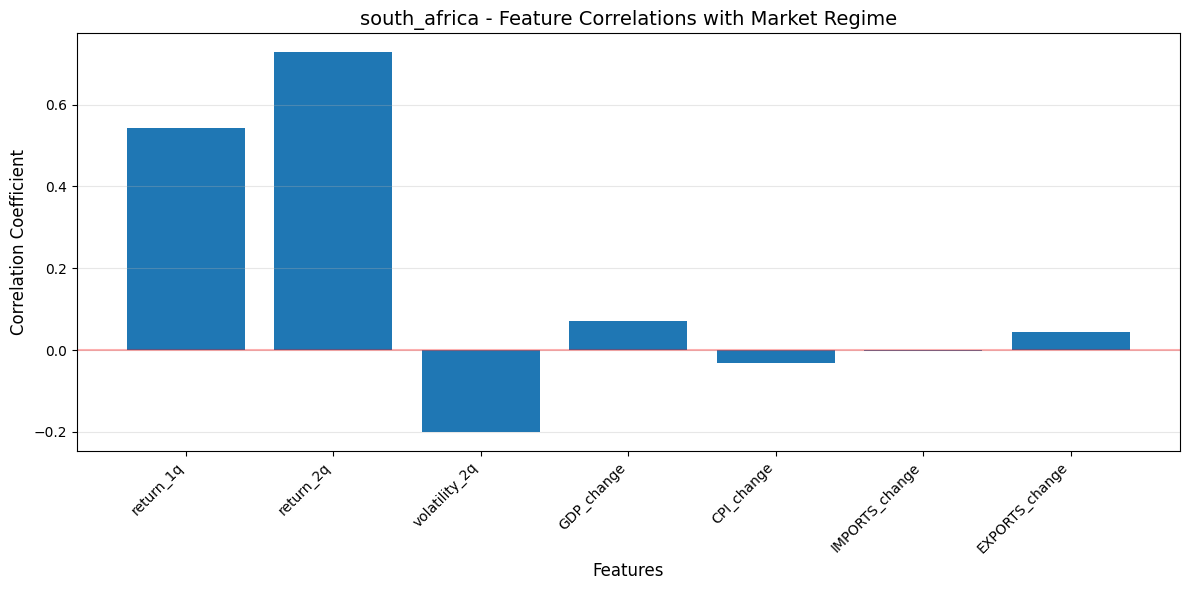


5. Model Training and Evaluation:
   - Training on 101 samples, testing on 44 samples
   - Training data shape: (101, 7)
   - Test data shape: (44, 7)
   - NaN values in training set: 44
   - NaN values in test set: 0
   - Model Accuracy: 0.64

   - Confusion Matrix:
[[ 7  9  0]
 [ 2  6  4]
 [ 0  1 15]]

   - Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.44      0.56        16
           1       0.38      0.50      0.43        12
           2       0.79      0.94      0.86        16

    accuracy                           0.64        44
   macro avg       0.65      0.62      0.62        44
weighted avg       0.67      0.64      0.63        44



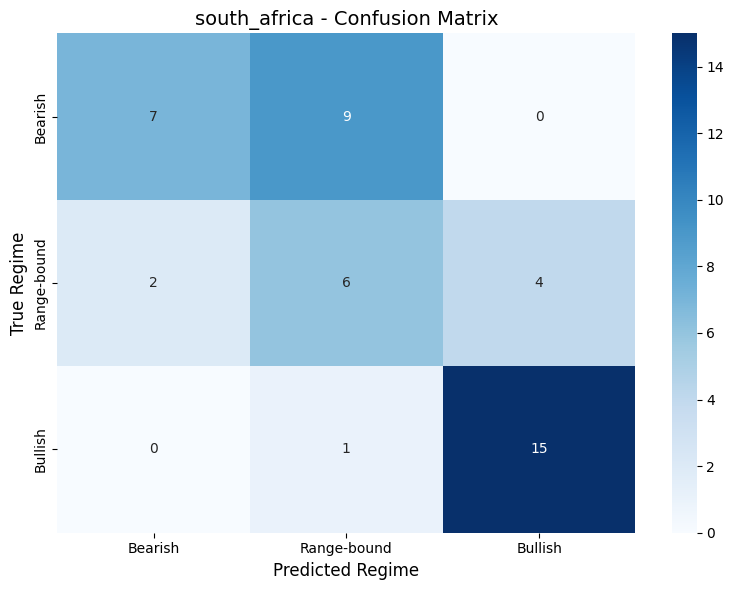


Summary of Results:
Brazil: Accuracy = 0.59
India: Accuracy = 0.61
South_Africa: Accuracy = 0.64


In [33]:
def run_market_regime_analysis():
    """Main function to run the entire market regime classification pipeline with debugging"""
    # Define countries to analyze
    countries = ['brazil', 'india', 'south_africa']

    # Store results
    results = {}

    for country in countries:
        print(f"\n{'='*50}")
        print(f"Processing {country.upper()}")
        print(f"{'='*50}")

        try:
            # Load and process data
            data = load_and_process_data(country)

            if data is None or data.empty:
                print(f"No valid data for {country}")
                continue

            # Engineer features
            featured_data = engineer_features(data)
            if featured_data is not None:
                print(f"Engineered features. Shape: {featured_data.shape}")

            # Label market regimes
            labeled_data = label_market_regimes(featured_data)
            if labeled_data is not None:
                print("Regime distribution:")
                print(labeled_data['regime'].value_counts())

            # Debug model training and evaluation
            debug_info = debug_model_training(labeled_data, country)

            # Store results if debugging was successful
            if debug_info is not None:
                results[country] = {
                    'model': debug_info.get('model'),
                    'accuracy': debug_info.get('accuracy')
                }

        except Exception as e:
            print(f"Error analyzing {country}: {str(e)}")
            import traceback
            traceback.print_exc()

    # Print summary
    print("\nSummary of Results:")
    for country, result in results.items():
        accuracy = result.get('accuracy')
        if accuracy is not None:
            print(f"{country.title()}: Accuracy = {accuracy:.2f}")
        else:
            print(f"{country.title()}: Analysis failed")

    return results

# Run the main analysis
if __name__ == "__main__":
    results = run_market_regime_analysis()
